In [1]:
from Utils.Helper import Run
from Config import Config, ParameterTable

import torch.backends.cudnn as cudnn
import numpy as np
from matplotlib import pyplot as plt

# cudnn.benchmark = True # This will break reproducibility
cudnn.deterministic = True # For reproducibility

In [2]:
def get_param_set_ID(pop_serial_num, param_set_index):
    return 'Pop_' + str(pop_serial_num) + '_ParamSet_' + str(param_set_index)


num_epochs = 10
prep_util_percent = 0.1
test_util_percent = 1.0

pop_size = 8
mut_prob = 0.1
max_iter = 50

saved_param_sets = {}
temp_param_set_list = []
for i in range(pop_size):
    parameterTable = ParameterTable(num_epochs, temp_param_set_list)
    parameterTable.ChooseParam()
    param_set_ID = get_param_set_ID(0, i)
    parameterTable.SaveParamSet(param_set_ID)
    saved_param_sets[param_set_ID] = parameterTable.GetListParamSet()
    temp_param_set_list.append(parameterTable.GetListParamSet())
del temp_param_set_list
    
gen_len = len(saved_param_sets[get_param_set_ID(0, 0)])

vid_acc_record = {}
fitness_record = {}
mean_fitness_record = []
best_acc = {'ID': None, 'value': 0}
best_vid_acc = {'ID': None, 'value': 0}
best_loss = {'ID': None, 'value': 999}
best_fitness = {'ID': None, 'value': 0}

In [3]:
def run_pop(pop_serial_num):
    
    def test_param_set(param_set_ID):
        config = Config()
        config.train.num_epochs = num_epochs
        config.prep.util_percent = prep_util_percent
        config.test.util_percent = test_util_percent
        config.test.verbose = False
        config.train.verbose = False
        config.basic.tryID = param_set_ID
        parameterTable = ParameterTable(config.train.num_epochs)
        parameterTable.LoadParamSet(param_set_ID)
        parameterTable.ApplyToConfig(config)
        config.apply()
        vid_accs, accs, losses = Run(config)
        display(parameterTable.param_set)
        return vid_accs, accs, losses

    def update_best_result(param_set_ID, vid_accs, accs, losses, fitness):
        if max(accs) > best_acc['value']:
            print("==========\n >> N E W   B E S T   A C C : ", max(accs), "\n==========")
            best_acc['value'] = max(accs)
            best_acc['ID'] = param_set_ID
        if max(vid_accs) > best_vid_acc['value']:
            print("==========\n >> N E W   B E S T   V I D   A C C : ", max(vid_accs), "\n==========")
            best_vid_acc['value'] = max(vid_accs)
            best_vid_acc['ID'] = param_set_ID
        if min(losses) < best_loss['value']:
            print("==========\n >> N E W   B E S T   L O S S : ", min(losses), "\n==========")
            best_loss['value'] = min(losses)
            best_loss['ID'] = param_set_ID
        if fitness > best_fitness['value']:
            print("==========\n >> N E W   B E S T   F I T N E S S : ", fitness, "\n==========")
            best_fitness['value'] = fitness
            best_fitness['ID'] = param_set_ID

    def get_fitness(vid_accs:list, sample_num=3):
        vid_accs = vid_accs.copy()
        vid_accs.sort(reverse=True)
        return sum(vid_accs[:sample_num]) / sample_num
    
    temp_fitness_record = []
    for i in range(pop_size):
        param_set_ID = get_param_set_ID(pop_serial_num, i)
        vid_accs, accs, losses = test_param_set(param_set_ID)
        fitness = get_fitness(vid_accs)
        update_best_result(param_set_ID, vid_accs, accs, losses, fitness)
        vid_acc_record[param_set_ID] = max(vid_accs)
        fitness_record[param_set_ID] = fitness
        temp_fitness_record.append(fitness)
    mean_fitness_record.append(sum(temp_fitness_record) / len(temp_fitness_record))
    
    
def get_new_pop(next_pop_serial_num):

    def get_child():
        parent1_ID, parent2_ID = np.random.choice(
            [x['ID'] for x in best_pop], 2, replace=False, p=softmax_fitness
        ).tolist()
        exchange_gen_num = np.random.randint(1, gen_len)
        exchange_gen_indices = np.random.choice(
            [i for i in range(gen_len)], exchange_gen_num, replace=False
        ).tolist()
        child = saved_param_sets[parent1_ID].copy()
        for i in exchange_gen_indices:
            child[i] = saved_param_sets[parent2_ID][i]
        for i in range(gen_len):
            if np.random.rand() > mut_prob:
                continue
            while True:
                parameterTable = ParameterTable(num_epochs)
                parameterTable.ChooseParam()
                temp_param_list = parameterTable.GetListParamSet()
                if temp_param_list[i] != child[i]:
                    child[i] = temp_param_list[i]
                    break
        return child, parent1_ID, parent2_ID

    def child_check(child):
        # Check if child is in saved_param_sets
        for key in saved_param_sets.keys():
            if child == saved_param_sets[key]:
                return False
        return True

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    best_pop = []
    temp_fitness_record = []
    for key in fitness_record.keys():
        temp_fitness_record.append({'ID': key, 'value': fitness_record[key] })
    temp_fitness_record.sort(key=lambda x: x['value'], reverse=True)
    for i in range(pop_size):
        best_pop.append({'ID': temp_fitness_record[i]['ID'], 'value': temp_fitness_record[i]['value']})
    del temp_fitness_record
    # Use softmax of fitness as probability to choose parent
    softmax_fitness = softmax([x['value'] for x in best_pop])
    for i in zip(best_pop, softmax_fitness):
        print(i)
    for i in range(pop_size):
        child, parent1_ID, parent2_ID = get_child()
        while not child_check(child):
            child, parent1_ID, parent2_ID = get_child()
        print(" - Got child from", parent1_ID, parent2_ID)
        parameterTable = ParameterTable(num_epochs)
        parameterTable.SetParamSetByList(child)
        param_set_ID = get_param_set_ID(next_pop_serial_num, i)
        parameterTable.SaveParamSet(param_set_ID)
        saved_param_sets[param_set_ID] = child

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 6.50
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 5.525
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 4.696250000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 3.9918125000000013
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 3.3930406250000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 2.884084531250002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 2.451471851562502
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 2.083751073828127
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 1.7711884127539081
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 1.5055101508408222
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting gaze weight to 1.279683628214699
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


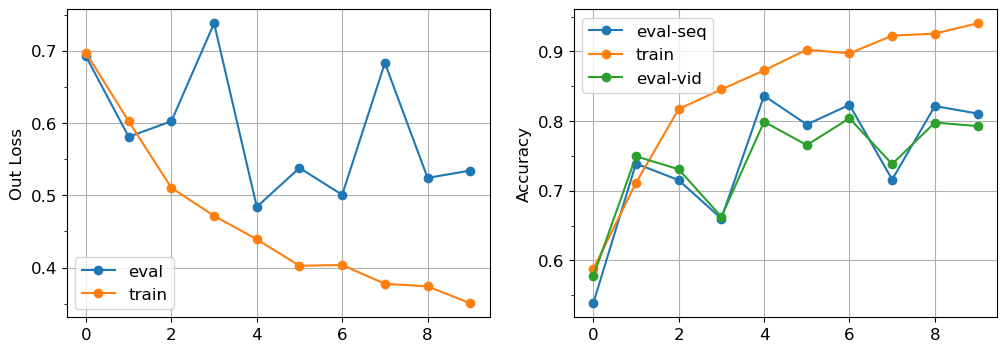

{'model_seed': 16,
 'leaky': 64,
 'head_dim': 6,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 2,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 1.7999999999999997e-05,
 'weight_decay': 0.0001,
 'gamma': 1.0,
 'gaze_weight': 6.5,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 2022,
 'smooth_label_alpha': 0.05,
 'smooth_label_beta': 0.05}

 >> N E W   B E S T   A C C :  0.8363420427553444 
 >> N E W   B E S T   V I D   A C C :  0.8039702233250621 
 >> N E W   B E S T   L O S S :  0.4839325324762241 
 >> N E W   B E S T   F I T N E S S :  0.8002481389578163 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.50
 - Model Structure:     Basic + Leaky * 192
------------------------------
Adjusting learning rate of group 0 to 1.0000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.7000e-06.
Adjusting gaze weight to 2.835
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.4090e-06.
Adjusting gaze weight to 2.2963500000000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.1267e-06.
Adjusting gaze weight to 1.8600435000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.8529e-06.
Adjusting gaze weight to 1.5066352350000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.5873e-06.
Adjusting gaze weight to 1.2203745403500006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.3297e-06.
Adjusting gaze weight to 0.9885033776835005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.0798e-06.
Adjusting gaze weight to 0.8006877359236354
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.8374e-06.
Adjusting gaze weight to 0.6485570660981447
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.6023e-06.
Adjusting gaze weight to 0.5253312235394972
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.3742e-06.
Adjusting gaze weight to 0.4255182910669928
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


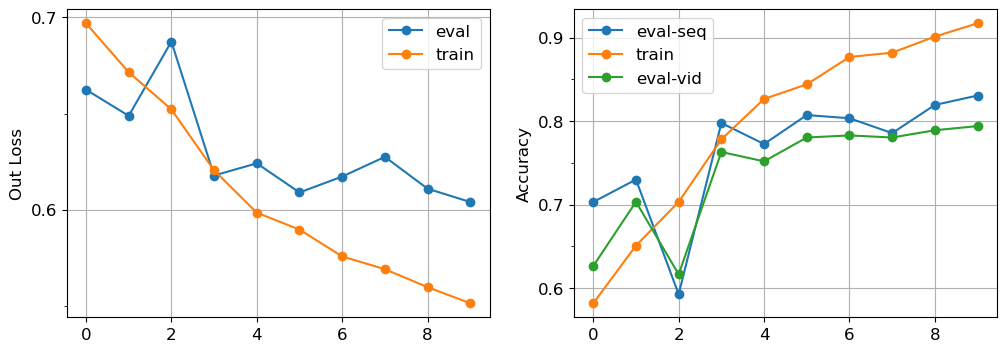

{'model_seed': 2048,
 'leaky': 192,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 0,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 1e-05,
 'weight_decay': 0.0001,
 'gamma': 0.9700000000000001,
 'gaze_weight': 3.5,
 'gaze_gamma': 0.81,
 'train_seed': 2023,
 'smooth_label_alpha': 0.2,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.50
 - Model Structure:     Basic + Leaky * 128
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7640e-05.
Adjusting gaze weight to 3.115
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7287e-05.
Adjusting gaze weight to 2.7723500000000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6941e-05.
Adjusting gaze weight to 2.467391500000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6603e-05.
Adjusting gaze weight to 2.195978435000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6271e-05.
Adjusting gaze weight to 1.9544208071500013
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5945e-05.
Adjusting gaze weight to 1.7394345183635014
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5626e-05.
Adjusting gaze weight to 1.5480967213435164
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5314e-05.
Adjusting gaze weight to 1.3778060819957298
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5007e-05.
Adjusting gaze weight to 1.2262474129761998
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4707e-05.
Adjusting gaze weight to 1.0913601975488179
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


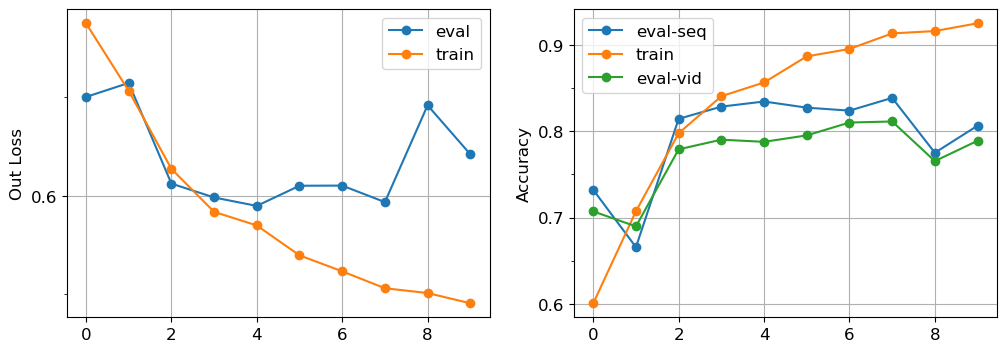

{'model_seed': 65535,
 'leaky': 128,
 'head_dim': 8,
 'dim_per_head': 64,
 'comp_dim': 96,
 'gaze_fc_layer_num': 1,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 1.7999999999999997e-05,
 'weight_decay': 0.001,
 'gamma': 0.9800000000000001,
 'gaze_weight': 3.5,
 'gaze_gamma': 0.8900000000000001,
 'train_seed': 2024,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

 >> N E W   B E S T   A C C :  0.8387173396674584 
 >> N E W   B E S T   V I D   A C C :  0.8114143920595533 
 >> N E W   B E S T   F I T N E S S :  0.8056244830438378 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 2.50
 - Model Structure:     Basic + Leaky * 160
------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5680e-05.
Adjusting gaze weight to 2.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5366e-05.
Adjusting gaze weight to 2.3040000000000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5059e-05.
Adjusting gaze weight to 2.211840000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4758e-05.
Adjusting gaze weight to 2.1233664000000014
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4463e-05.
Adjusting gaze weight to 2.0384317440000017
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4173e-05.
Adjusting gaze weight to 1.956894474240002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3890e-05.
Adjusting gaze weight to 1.8786186952704023
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3612e-05.
Adjusting gaze weight to 1.8034739474595864
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3340e-05.
Adjusting gaze weight to 1.7313349895612034
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3073e-05.
Adjusting gaze weight to 1.6620815899787555
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


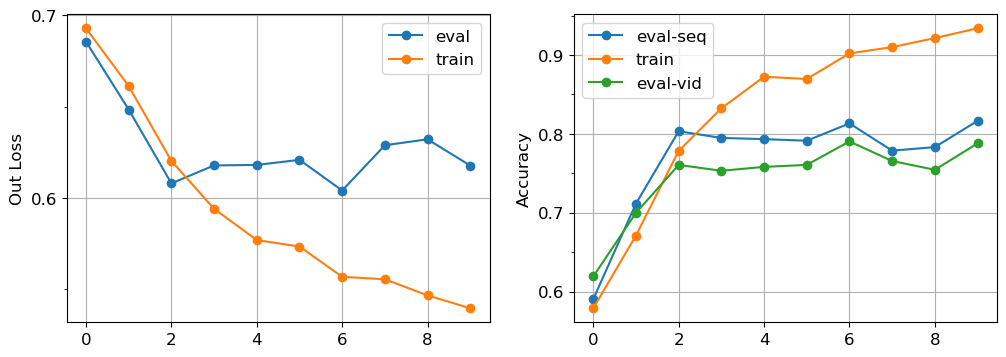

{'model_seed': 2,
 'leaky': 160,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 48,
 'gaze_fc_layer_num': 1,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 2,
 'lr': 1.6e-05,
 'weight_decay': 0.0001,
 'gamma': 0.9800000000000001,
 'gaze_weight': 2.5,
 'gaze_gamma': 0.9600000000000002,
 'train_seed': 8,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.00
 - Model Structure:     Basic + Leaky * 256
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6740e-05.
Adjusting gaze weight to 2.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5568e-05.
Adjusting gaze weight to 1.9200000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4478e-05.
Adjusting gaze weight to 1.5360000000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3465e-05.
Adjusting gaze weight to 1.2288000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2522e-05.
Adjusting gaze weight to 0.9830400000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1646e-05.
Adjusting gaze weight to 0.7864320000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0831e-05.
Adjusting gaze weight to 0.6291456000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0072e-05.
Adjusting gaze weight to 0.5033164800000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3674e-06.
Adjusting gaze weight to 0.40265318400000033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.7117e-06.
Adjusting gaze weight to 0.3221225472000003
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


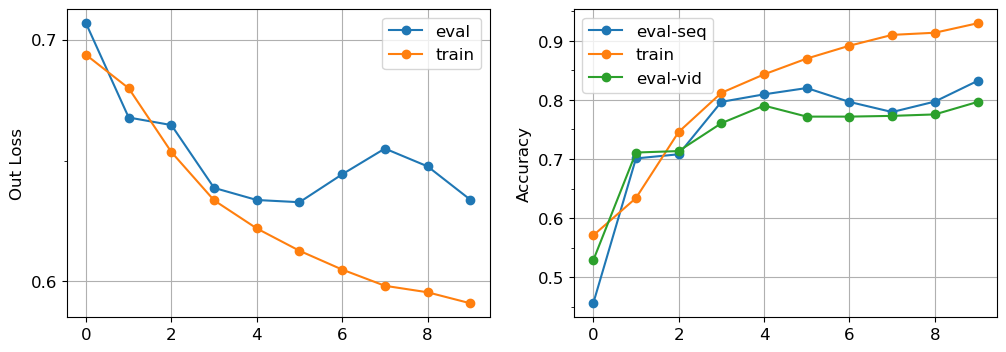

{'model_seed': 1,
 'leaky': 256,
 'head_dim': 8,
 'dim_per_head': 32,
 'comp_dim': 32,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 1.7999999999999997e-05,
 'weight_decay': 0.001,
 'gamma': 0.93,
 'gaze_weight': 3.0,
 'gaze_gamma': 0.8,
 'train_seed': 1,
 'smooth_label_alpha': 0.2,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 5.00
 - Model Structure:     Basic + Leaky * 160
------------------------------
Adjusting learning rate of group 0 to 1.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1280e-05.
Adjusting gaze weight to 4.700000000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0603e-05.
Adjusting gaze weight to 4.418000000000002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.9670e-06.
Adjusting gaze weight to 4.152920000000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3690e-06.
Adjusting gaze weight to 3.9037448000000032
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.8068e-06.
Adjusting gaze weight to 3.669520112000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.2784e-06.
Adjusting gaze weight to 3.4493489052800044
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.7817e-06.
Adjusting gaze weight to 3.242387970963205
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.3148e-06.
Adjusting gaze weight to 3.047844692705413
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.8759e-06.
Adjusting gaze weight to 2.864974011143089
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.4634e-06.
Adjusting gaze weight to 2.693075570474504
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


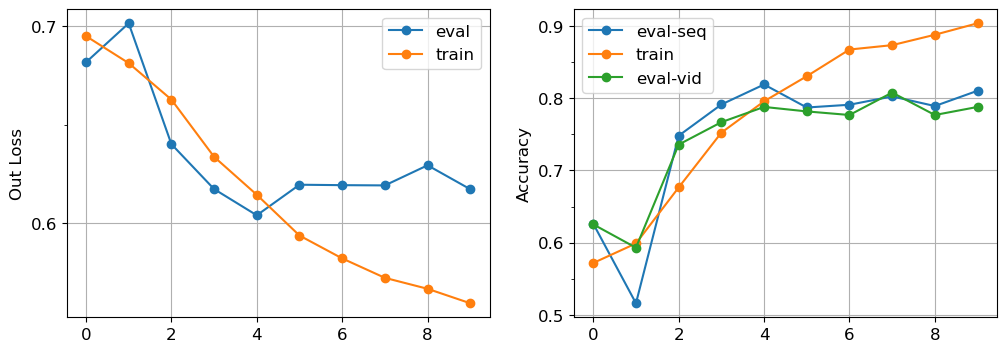

{'model_seed': 1024,
 'leaky': 160,
 'head_dim': 6,
 'dim_per_head': 32,
 'comp_dim': 96,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 2,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 1.2e-05,
 'weight_decay': 1e-06,
 'gamma': 0.9400000000000001,
 'gaze_weight': 5.0,
 'gaze_gamma': 0.9400000000000002,
 'train_seed': 2024,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0680e-05.
Adjusting gaze weight to 3.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9439e-05.
Adjusting gaze weight to 2.8900000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8273e-05.
Adjusting gaze weight to 2.4565000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7176e-05.
Adjusting gaze weight to 2.088025000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6146e-05.
Adjusting gaze weight to 1.774821250000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5177e-05.
Adjusting gaze weight to 1.5085980625000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4267e-05.
Adjusting gaze weight to 1.2823083531250008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3411e-05.
Adjusting gaze weight to 1.0899621001562507
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2606e-05.
Adjusting gaze weight to 0.9264677851328132
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1850e-05.
Adjusting gaze weight to 0.7874976173628914
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


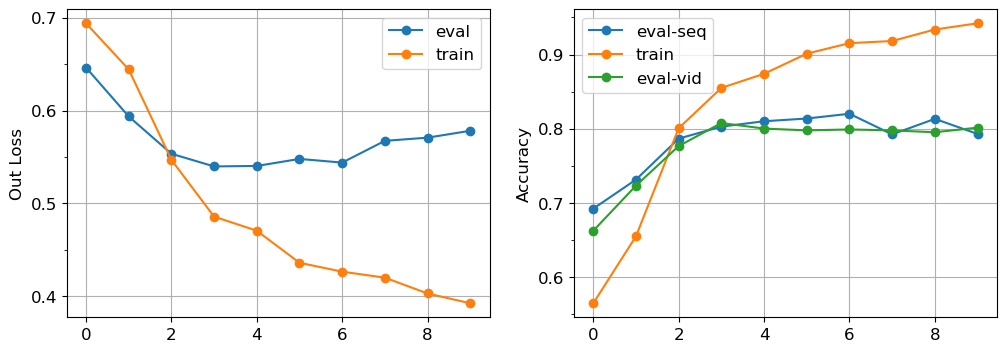

{'model_seed': 65535,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 11.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 1.0000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3000e-06.
Adjusting gaze weight to 10.340000000000002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.6490e-06.
Adjusting gaze weight to 9.719600000000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.0436e-06.
Adjusting gaze weight to 9.136424000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.4805e-06.
Adjusting gaze weight to 8.588238560000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.9569e-06.
Adjusting gaze weight to 8.072944246400008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.4699e-06.
Adjusting gaze weight to 7.588567591616009
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.0170e-06.
Adjusting gaze weight to 7.133253536119049
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 5.5958e-06.
Adjusting gaze weight to 6.705258323951908
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 5.2041e-06.
Adjusting gaze weight to 6.302942824514794
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 4.8398e-06.
Adjusting gaze weight to 5.924766255043908
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


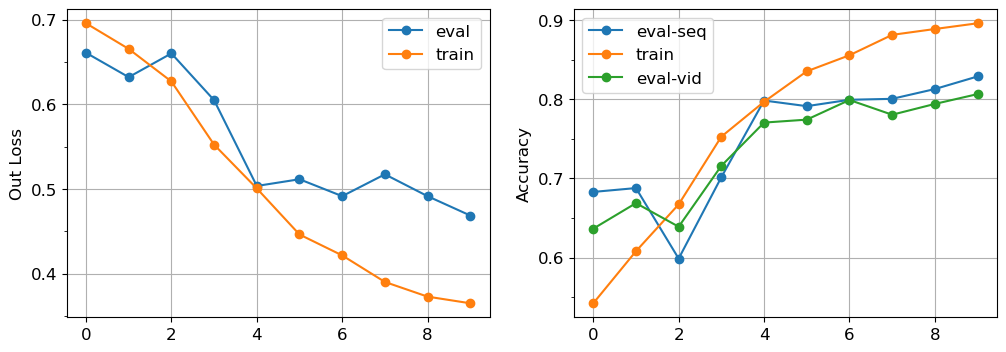

{'model_seed': 1,
 'leaky': 96,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 80,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 1e-05,
 'weight_decay': 1e-05,
 'gamma': 0.93,
 'gaze_weight': 11.0,
 'gaze_gamma': 0.9400000000000002,
 'train_seed': 4,
 'smooth_label_alpha': 0.05,
 'smooth_label_beta': 0.0}

 >> N E W   B E S T   L O S S :  0.46860756026713596 
({'ID': 'Pop_0_ParamSet_2', 'value': 0.8056244830438378}, 0.1263211313071459)
({'ID': 'Pop_0_ParamSet_6', 'value': 0.8031430934656741}, 0.12600806794513564)
({'ID': 'Pop_0_ParamSet_0', 'value': 0.8002481389578163}, 0.12564380783343568)
({'ID': 'Pop_0_ParamSet_7', 'value': 0.7998345740281224}, 0.12559185670420558)
({'ID': 'Pop_0_ParamSet_5', 'value': 0.7944582299421009}, 0.12491844354068846)
({'ID': 'Pop_0_ParamSet_1', 'value': 0.7886683209263854}, 0.12419726690642008)
({'ID': 'Pop_0_ParamSet_4', 'value': 0.7874276261373035}, 0.12404327155492022)
({'ID': 'Pop_0_ParamSet_3', 'value': 0.7812241521918941}, 0.12327615420804865)
 - Got child from Pop_0_ParamSet_4 Pop_0_ParamSet_1
 - Got child from Pop_0_ParamSet_7 Pop_0_ParamSet_6
 - Got child from Pop_0_ParamSet_3 Pop_0_ParamSet_5
 - Got child from Pop_0_ParamSet_6 Pop_0_ParamSet_5
 - Got child from Pop_0_ParamSet_6 Pop_0_ParamSet_3
 - Got child from Pop_0_ParamSet_6 Pop_0_ParamSet_3
 - 

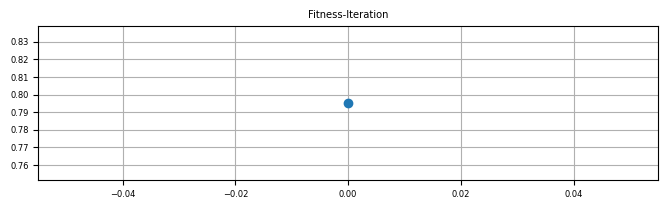

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.00
 - Model Structure:     Basic + Leaky * 256
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6740e-05.
Adjusting gaze weight to 2.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5568e-05.
Adjusting gaze weight to 1.9200000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4478e-05.
Adjusting gaze weight to 1.5360000000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3465e-05.
Adjusting gaze weight to 1.2288000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2522e-05.
Adjusting gaze weight to 0.9830400000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1646e-05.
Adjusting gaze weight to 0.7864320000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0831e-05.
Adjusting gaze weight to 0.6291456000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0072e-05.
Adjusting gaze weight to 0.5033164800000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3674e-06.
Adjusting gaze weight to 0.40265318400000033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.7117e-06.
Adjusting gaze weight to 0.3221225472000003
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


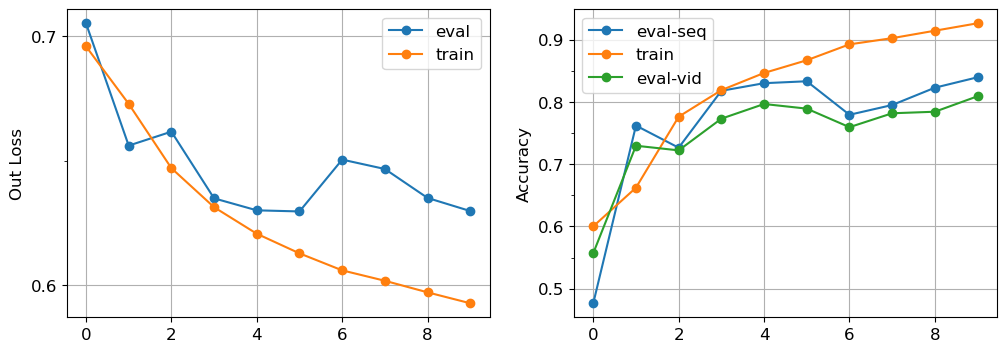

{'model_seed': 2048,
 'leaky': 256,
 'head_dim': 8,
 'dim_per_head': 32,
 'comp_dim': 32,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 1.7999999999999997e-05,
 'weight_decay': 0.001,
 'gamma': 0.93,
 'gaze_weight': 3.0,
 'gaze_gamma': 0.8,
 'train_seed': 1,
 'smooth_label_alpha': 0.2,
 'smooth_label_beta': 0.1}

 >> N E W   B E S T   A C C :  0.8394299287410927 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0460e-05.
Adjusting gaze weight to 2.5500000000000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9028e-05.
Adjusting gaze weight to 2.1675000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7696e-05.
Adjusting gaze weight to 1.8423750000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6457e-05.
Adjusting gaze weight to 1.5660187500000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5305e-05.
Adjusting gaze weight to 1.3311159375000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4234e-05.
Adjusting gaze weight to 1.1314485468750008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3237e-05.
Adjusting gaze weight to 0.9617312648437508
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2311e-05.
Adjusting gaze weight to 0.8174715751171883
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1449e-05.
Adjusting gaze weight to 0.6948508388496101
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0648e-05.
Adjusting gaze weight to 0.5906232130221686
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


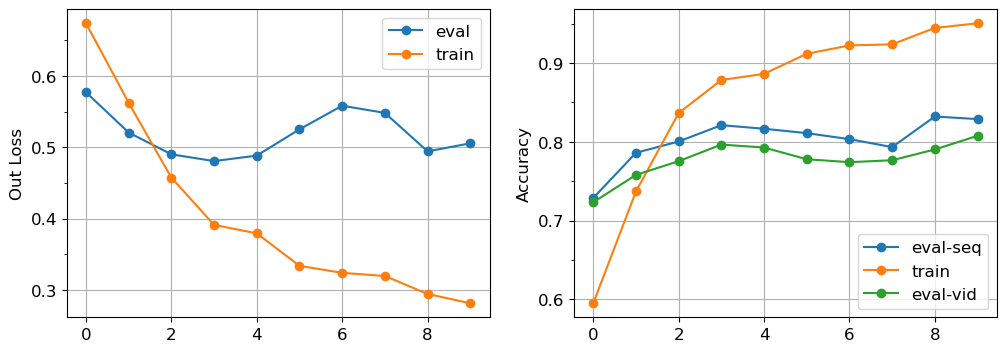

{'model_seed': 65535,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 64,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.93,
 'gaze_weight': 3.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 256,
 'smooth_label_alpha': 0.05,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 2.50
 - Model Structure:     Basic + Leaky * 160
------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5680e-05.
Adjusting gaze weight to 2.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5366e-05.
Adjusting gaze weight to 2.3040000000000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5059e-05.
Adjusting gaze weight to 2.211840000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4758e-05.
Adjusting gaze weight to 2.1233664000000014
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4463e-05.
Adjusting gaze weight to 2.0384317440000017
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4173e-05.
Adjusting gaze weight to 1.956894474240002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3890e-05.
Adjusting gaze weight to 1.8786186952704023
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3612e-05.
Adjusting gaze weight to 1.8034739474595864
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3340e-05.
Adjusting gaze weight to 1.7313349895612034
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3073e-05.
Adjusting gaze weight to 1.6620815899787555
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


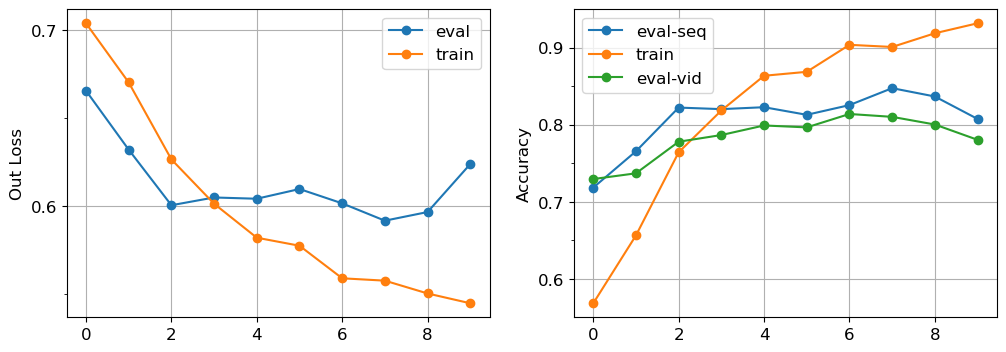

{'model_seed': 2,
 'leaky': 160,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 96,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 2,
 'lr': 1.6e-05,
 'weight_decay': 1e-06,
 'gamma': 0.9800000000000001,
 'gaze_weight': 2.5,
 'gaze_gamma': 0.9600000000000002,
 'train_seed': 8,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

 >> N E W   B E S T   A C C :  0.8473871733966746 
 >> N E W   B E S T   V I D   A C C :  0.8138957816377171 
 >> N E W   B E S T   F I T N E S S :  0.8081058726220016 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0680e-05.
Adjusting gaze weight to 3.7600000000000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9439e-05.
Adjusting gaze weight to 3.534400000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8273e-05.
Adjusting gaze weight to 3.3223360000000017
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7176e-05.
Adjusting gaze weight to 3.1229958400000024
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6146e-05.
Adjusting gaze weight to 2.935616089600003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5177e-05.
Adjusting gaze weight to 2.7594791242240033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4267e-05.
Adjusting gaze weight to 2.593910376770564
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3411e-05.
Adjusting gaze weight to 2.4382757541643305
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2606e-05.
Adjusting gaze weight to 2.291979208914471
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1850e-05.
Adjusting gaze weight to 2.1544604563796033
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


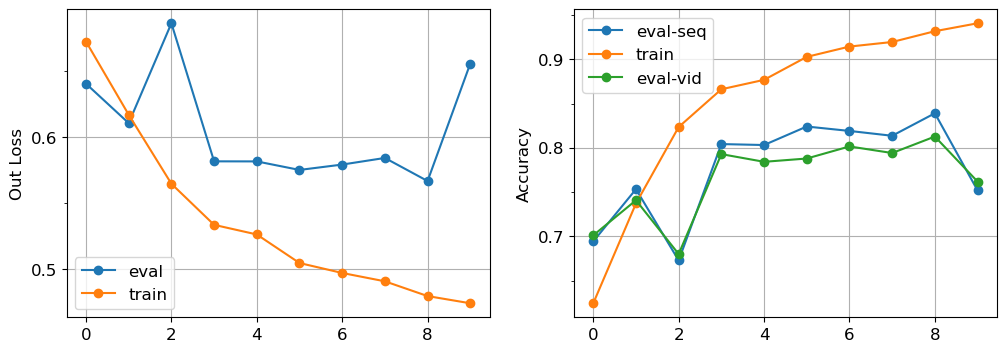

{'model_seed': 1024,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 96,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 2,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 2.2e-05,
 'weight_decay': 1e-06,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.9400000000000002,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 2.50
 - Model Structure:     Basic + Leaky * 160
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.1560e-05.
Adjusting gaze weight to 2.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.1129e-05.
Adjusting gaze weight to 2.3040000000000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0706e-05.
Adjusting gaze weight to 2.211840000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0292e-05.
Adjusting gaze weight to 2.1233664000000014
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9886e-05.
Adjusting gaze weight to 2.0384317440000017
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9489e-05.
Adjusting gaze weight to 1.956894474240002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9099e-05.
Adjusting gaze weight to 1.8786186952704023
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8717e-05.
Adjusting gaze weight to 1.8034739474595864
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8342e-05.
Adjusting gaze weight to 1.7313349895612034
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7976e-05.
Adjusting gaze weight to 1.6620815899787555
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


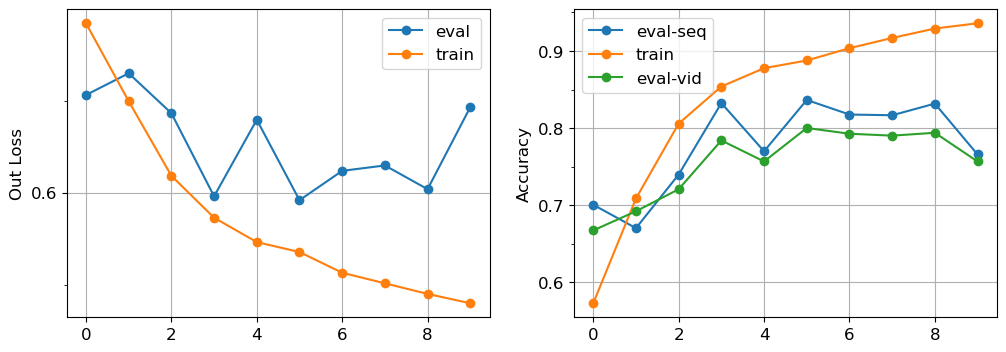

{'model_seed': 2,
 'leaky': 160,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 1,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 2.2e-05,
 'weight_decay': 0.0001,
 'gamma': 0.9800000000000001,
 'gaze_weight': 2.5,
 'gaze_gamma': 0.9600000000000002,
 'train_seed': 2023,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 160
------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5040e-05.
Adjusting gaze weight to 3.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4138e-05.
Adjusting gaze weight to 2.8900000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3289e-05.
Adjusting gaze weight to 2.4565000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2492e-05.
Adjusting gaze weight to 2.088025000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1742e-05.
Adjusting gaze weight to 1.774821250000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1038e-05.
Adjusting gaze weight to 1.5085980625000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0376e-05.
Adjusting gaze weight to 1.2823083531250008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.7531e-06.
Adjusting gaze weight to 1.0899621001562507
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.1679e-06.
Adjusting gaze weight to 0.9264677851328132
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.6178e-06.
Adjusting gaze weight to 0.7874976173628914
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


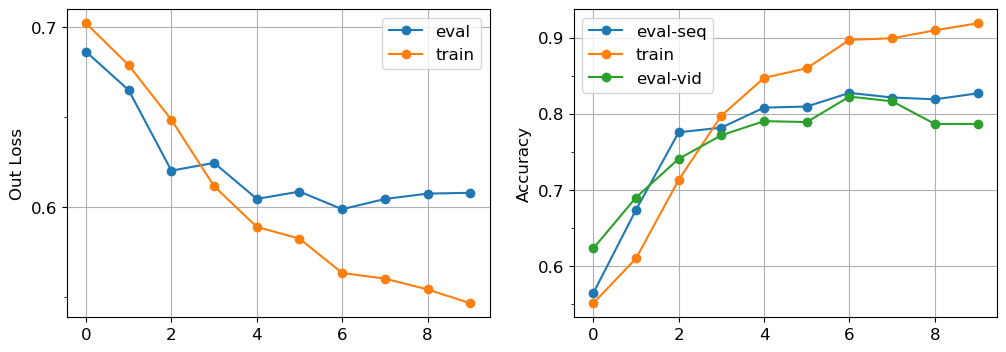

{'model_seed': 65535,
 'leaky': 160,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 48,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 1.6e-05,
 'weight_decay': 0.001,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 8,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

 >> N E W   B E S T   V I D   A C C :  0.8225806451612904 
 >> N E W   B E S T   F I T N E S S :  0.8097601323407776 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.00
 - Model Structure:     Basic + Leaky * 192
------------------------------
Adjusting learning rate of group 0 to 1.0000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.7000e-06.
Adjusting gaze weight to 2.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.4090e-06.
Adjusting gaze weight to 1.9200000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.1267e-06.
Adjusting gaze weight to 1.5360000000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.8529e-06.
Adjusting gaze weight to 1.2288000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.5873e-06.
Adjusting gaze weight to 0.9830400000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.3297e-06.
Adjusting gaze weight to 0.7864320000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.0798e-06.
Adjusting gaze weight to 0.6291456000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.8374e-06.
Adjusting gaze weight to 0.5033164800000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.6023e-06.
Adjusting gaze weight to 0.40265318400000033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.3742e-06.
Adjusting gaze weight to 0.3221225472000003
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


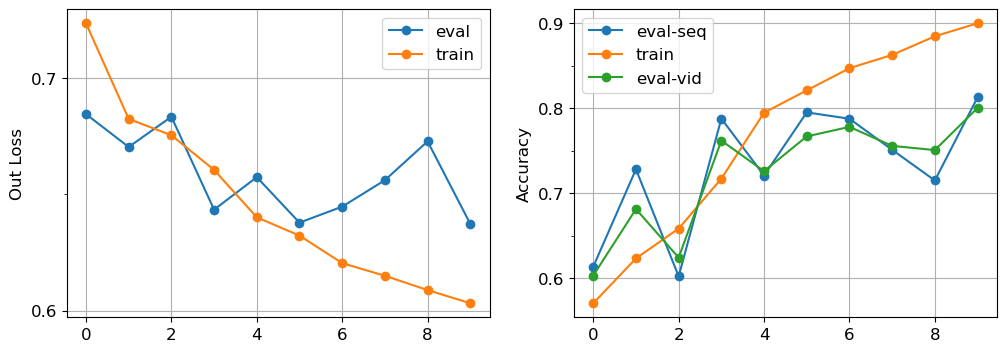

{'model_seed': 1,
 'leaky': 192,
 'head_dim': 8,
 'dim_per_head': 32,
 'comp_dim': 48,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 1e-05,
 'weight_decay': 0.001,
 'gamma': 0.9700000000000001,
 'gaze_weight': 3.0,
 'gaze_gamma': 0.8,
 'train_seed': 2023,
 'smooth_label_alpha': 0.2,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0680e-05.
Adjusting gaze weight to 3.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9439e-05.
Adjusting gaze weight to 2.8900000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8273e-05.
Adjusting gaze weight to 2.4565000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7176e-05.
Adjusting gaze weight to 2.088025000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6146e-05.
Adjusting gaze weight to 1.774821250000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5177e-05.
Adjusting gaze weight to 1.5085980625000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4267e-05.
Adjusting gaze weight to 1.2823083531250008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3411e-05.
Adjusting gaze weight to 1.0899621001562507
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2606e-05.
Adjusting gaze weight to 0.9264677851328132
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1850e-05.
Adjusting gaze weight to 0.7874976173628914
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


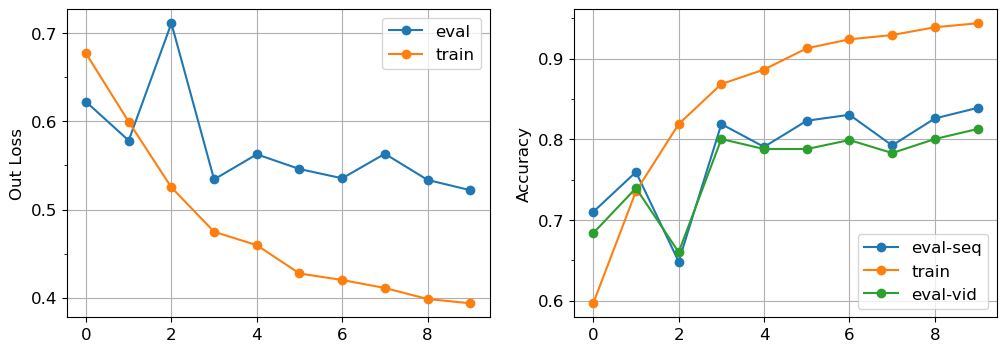

{'model_seed': 65535,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

({'ID': 'Pop_1_ParamSet_5', 'value': 0.8097601323407776}, 0.12569266747058724)
({'ID': 'Pop_1_ParamSet_2', 'value': 0.8081058726220016}, 0.1254849110427685)
({'ID': 'Pop_0_ParamSet_2', 'value': 0.8056244830438378}, 0.12517392009670827)
({'ID': 'Pop_1_ParamSet_7', 'value': 0.8043837882547559}, 0.1250187137680663)
({'ID': 'Pop_0_ParamSet_6', 'value': 0.8031430934656741}, 0.12486369988370057)
({'ID': 'Pop_1_ParamSet_3', 'value': 0.8027295285359801}, 0.12481207131305576)
({'ID': 'Pop_0_ParamSet_0', 'value': 0.8002481389578163}, 0.12450274787476481)
({'ID': 'Pop_0_ParamSet_7', 'value': 0.7998345740281224}, 0.12445126855034862)
 - Got child from Pop_0_ParamSet_0 Pop_1_ParamSet_5
 - Got child from Pop_0_ParamSet_0 Pop_0_ParamSet_7
 - Got child from Pop_0_ParamSet_6 Pop_0_ParamSet_7
 - Got child from Pop_1_ParamSet_7 Pop_0_ParamSet_7
 - Got child from Pop_1_ParamSet_5 Pop_0_ParamSet_7
 - Got child from Pop_0_ParamSet_7 Pop_0_ParamSet_6
 - Got child from Pop_0_ParamSet_2 Pop_1_ParamSet_7
 - Got

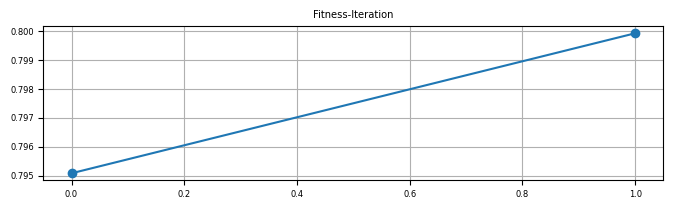

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 6.50
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 5.525
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 4.696250000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 3.9918125000000013
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 3.3930406250000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 2.884084531250002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 2.451471851562502
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 2.083751073828127
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 1.7711884127539081
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 1.5055101508408222
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
Adjusting gaze weight to 1.279683628214699
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


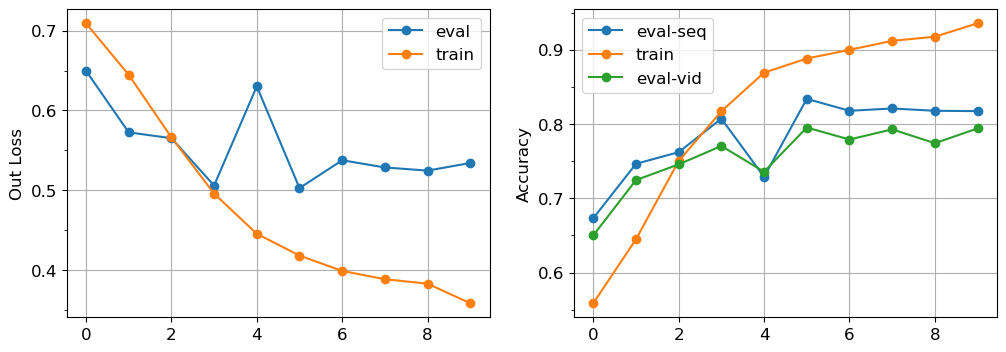

{'model_seed': 16,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 2,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 2,
 'lr': 1.6e-05,
 'weight_decay': 0.0001,
 'gamma': 1.0,
 'gaze_weight': 6.5,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 512,
 'smooth_label_alpha': 0.05,
 'smooth_label_beta': 0.05}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 6.50
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 1.0000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3000e-06.
Adjusting gaze weight to 5.525
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.6490e-06.
Adjusting gaze weight to 4.696250000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.0436e-06.
Adjusting gaze weight to 3.9918125000000013
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.4805e-06.
Adjusting gaze weight to 3.3930406250000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.9569e-06.
Adjusting gaze weight to 2.884084531250002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.4699e-06.
Adjusting gaze weight to 2.451471851562502
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.0170e-06.
Adjusting gaze weight to 2.083751073828127
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 5.5958e-06.
Adjusting gaze weight to 1.7711884127539081
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 5.2041e-06.
Adjusting gaze weight to 1.5055101508408222
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 4.8398e-06.
Adjusting gaze weight to 1.279683628214699
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


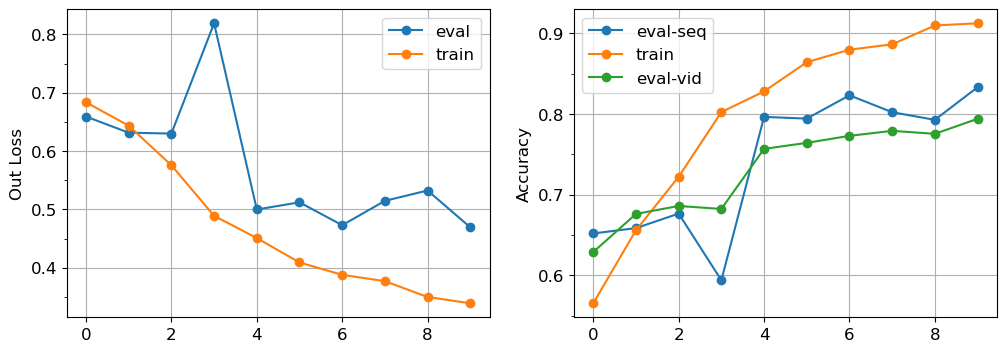

{'model_seed': 1,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 64,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 1e-05,
 'weight_decay': 1e-05,
 'gamma': 0.93,
 'gaze_weight': 6.5,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 4,
 'smooth_label_alpha': 0.05,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 11.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6740e-05.
Adjusting gaze weight to 10.340000000000002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5568e-05.
Adjusting gaze weight to 9.719600000000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4478e-05.
Adjusting gaze weight to 9.136424000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3465e-05.
Adjusting gaze weight to 8.588238560000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2522e-05.
Adjusting gaze weight to 8.072944246400008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1646e-05.
Adjusting gaze weight to 7.588567591616009
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0831e-05.
Adjusting gaze weight to 7.133253536119049
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0072e-05.
Adjusting gaze weight to 6.705258323951908
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3674e-06.
Adjusting gaze weight to 6.302942824514794
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.7117e-06.
Adjusting gaze weight to 5.924766255043908
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


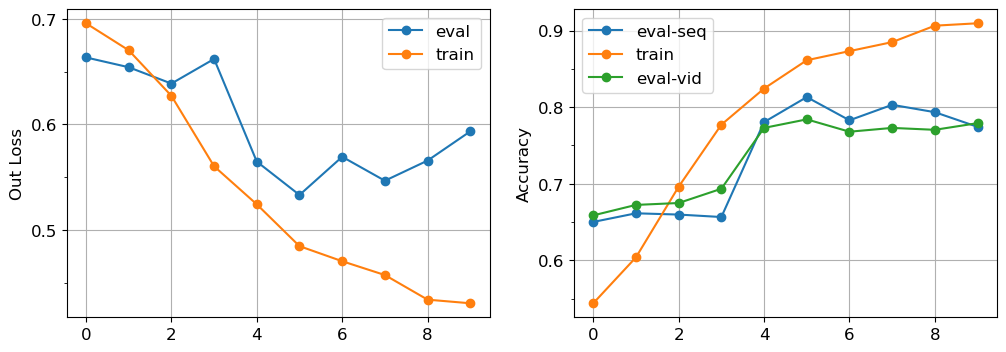

{'model_seed': 1,
 'leaky': 96,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 64,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 1.7999999999999997e-05,
 'weight_decay': 1e-05,
 'gamma': 0.93,
 'gaze_weight': 11.0,
 'gaze_gamma': 0.9400000000000002,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0680e-05.
Adjusting gaze weight to 3.880000000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9439e-05.
Adjusting gaze weight to 3.7636000000000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8273e-05.
Adjusting gaze weight to 3.6506920000000025
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7176e-05.
Adjusting gaze weight to 3.5411712400000033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6146e-05.
Adjusting gaze weight to 3.434936102800004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5177e-05.
Adjusting gaze weight to 3.3318880197160046
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4267e-05.
Adjusting gaze weight to 3.231931379124525
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3411e-05.
Adjusting gaze weight to 3.13497343775079
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2606e-05.
Adjusting gaze weight to 3.0409242346182666
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1850e-05.
Adjusting gaze weight to 2.949696507579719
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


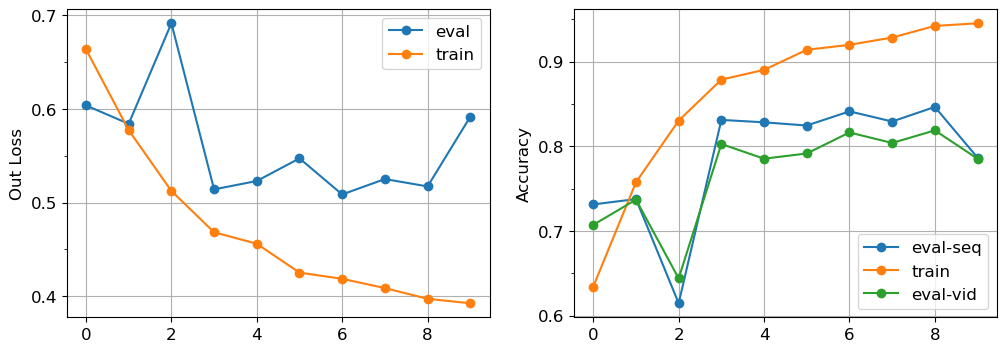

{'model_seed': 65535,
 'leaky': 96,
 'head_dim': 6,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 2,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.9700000000000002,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

 >> N E W   B E S T   F I T N E S S :  0.8130686517783291 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 1.0000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.3000e-06.
Adjusting gaze weight to 3.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.6490e-06.
Adjusting gaze weight to 2.8900000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.0436e-06.
Adjusting gaze weight to 2.4565000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.4805e-06.
Adjusting gaze weight to 2.088025000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.9569e-06.
Adjusting gaze weight to 1.774821250000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.4699e-06.
Adjusting gaze weight to 1.5085980625000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 6.0170e-06.
Adjusting gaze weight to 1.2823083531250008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 5.5958e-06.
Adjusting gaze weight to 1.0899621001562507
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 5.2041e-06.
Adjusting gaze weight to 0.9264677851328132
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 4.8398e-06.
Adjusting gaze weight to 0.7874976173628914
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


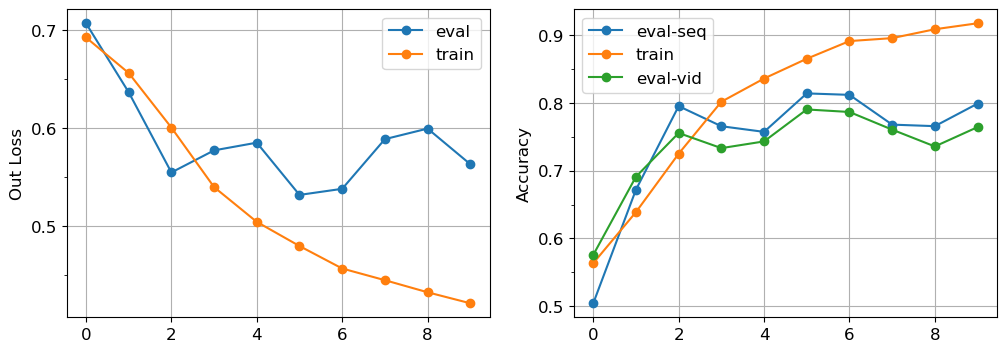

{'model_seed': 1,
 'leaky': 96,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 48,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 1e-05,
 'weight_decay': 1e-06,
 'gamma': 0.93,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 8,
 'smooth_label_alpha': 0.05,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 6.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0460e-05.
Adjusting gaze weight to 5.1000000000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9028e-05.
Adjusting gaze weight to 4.335000000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7696e-05.
Adjusting gaze weight to 3.684750000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6457e-05.
Adjusting gaze weight to 3.1320375000000014
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5305e-05.
Adjusting gaze weight to 2.6622318750000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4234e-05.
Adjusting gaze weight to 2.2628970937500017
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3237e-05.
Adjusting gaze weight to 1.9234625296875016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2311e-05.
Adjusting gaze weight to 1.6349431502343765
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1449e-05.
Adjusting gaze weight to 1.3897016776992202
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0648e-05.
Adjusting gaze weight to 1.1812464260443372
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


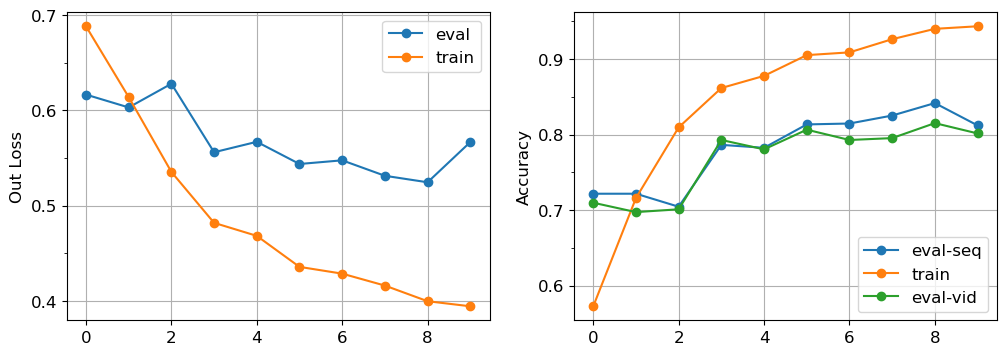

{'model_seed': 1,
 'leaky': 96,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 80,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.93,
 'gaze_weight': 6.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 128
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7640e-05.
Adjusting gaze weight to 3.7600000000000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7287e-05.
Adjusting gaze weight to 3.534400000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6941e-05.
Adjusting gaze weight to 3.3223360000000017
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6603e-05.
Adjusting gaze weight to 3.1229958400000024
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6271e-05.
Adjusting gaze weight to 2.935616089600003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5945e-05.
Adjusting gaze weight to 2.7594791242240033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5626e-05.
Adjusting gaze weight to 2.593910376770564
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5314e-05.
Adjusting gaze weight to 2.4382757541643305
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5007e-05.
Adjusting gaze weight to 2.291979208914471
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4707e-05.
Adjusting gaze weight to 2.1544604563796033
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


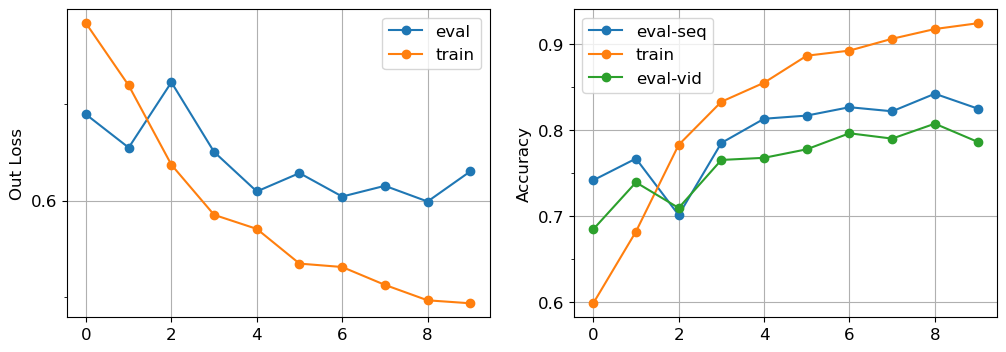

{'model_seed': 65535,
 'leaky': 128,
 'head_dim': 8,
 'dim_per_head': 64,
 'comp_dim': 96,
 'gaze_fc_layer_num': 1,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 1.7999999999999997e-05,
 'weight_decay': 0.001,
 'gamma': 0.9800000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.9400000000000002,
 'train_seed': 256,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 3.50
 - Model Structure:     Basic 
------------------------------
Adjusting learning rate of group 0 to 1.4000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3160e-05.
Adjusting gaze weight to 2.9750000000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2370e-05.
Adjusting gaze weight to 2.5287500000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1628e-05.
Adjusting gaze weight to 2.149437500000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0930e-05.
Adjusting gaze weight to 1.827021875000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0275e-05.
Adjusting gaze weight to 1.5529685937500008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.6582e-06.
Adjusting gaze weight to 1.320023304687501
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.0787e-06.
Adjusting gaze weight to 1.122019808984376
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.5340e-06.
Adjusting gaze weight to 0.9537168376367198
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.0219e-06.
Adjusting gaze weight to 0.8106593119912119
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 7.5406e-06.
Adjusting gaze weight to 0.6890604151925301
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


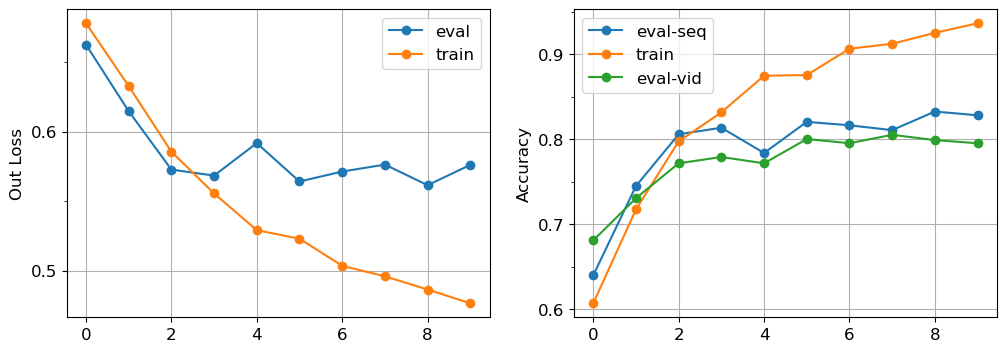

{'model_seed': 512,
 'leaky': 0,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 1.4e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9400000000000001,
 'gaze_weight': 3.5,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 8,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.0}

({'ID': 'Pop_2_ParamSet_3', 'value': 0.8130686517783291}, 0.125783656772166)
({'ID': 'Pop_1_ParamSet_5', 'value': 0.8097601323407776}, 0.12536818677308106)
({'ID': 'Pop_1_ParamSet_2', 'value': 0.8081058726220016}, 0.12516096667687154)
({'ID': 'Pop_2_ParamSet_5', 'value': 0.8076923076923076}, 0.12510921519252446)
({'ID': 'Pop_0_ParamSet_2', 'value': 0.8056244830438378}, 0.12485077856649875)
({'ID': 'Pop_1_ParamSet_7', 'value': 0.8043837882547559}, 0.1246959729092626)
({'ID': 'Pop_0_ParamSet_6', 'value': 0.8031430934656741}, 0.12454135919949999)
({'ID': 'Pop_1_ParamSet_3', 'value': 0.8027295285359801}, 0.12448986391009546)
 - Got child from Pop_2_ParamSet_3 Pop_2_ParamSet_5
 - Got child from Pop_1_ParamSet_3 Pop_1_ParamSet_5
 - Got child from Pop_0_ParamSet_6 Pop_2_ParamSet_3
 - Got child from Pop_1_ParamSet_7 Pop_0_ParamSet_6
 - Got child from Pop_1_ParamSet_3 Pop_2_ParamSet_3
 - Got child from Pop_0_ParamSet_2 Pop_1_ParamSet_3
 - Got child from Pop_0_ParamSet_2 Pop_2_ParamSet_3
 - Got 

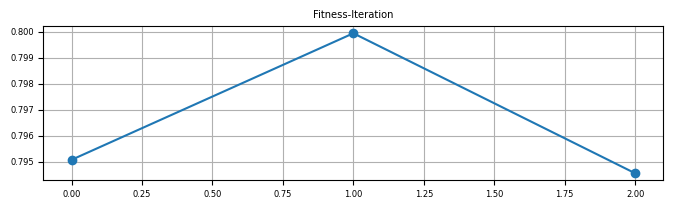

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.1120e-05.
Adjusting gaze weight to 3.880000000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0275e-05.
Adjusting gaze weight to 3.7636000000000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9464e-05.
Adjusting gaze weight to 3.6506920000000025
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8686e-05.
Adjusting gaze weight to 3.5411712400000033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7938e-05.
Adjusting gaze weight to 3.434936102800004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7221e-05.
Adjusting gaze weight to 3.3318880197160046
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6532e-05.
Adjusting gaze weight to 3.231931379124525
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5871e-05.
Adjusting gaze weight to 3.13497343775079
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5236e-05.
Adjusting gaze weight to 3.0409242346182666
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4626e-05.
Adjusting gaze weight to 2.949696507579719
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


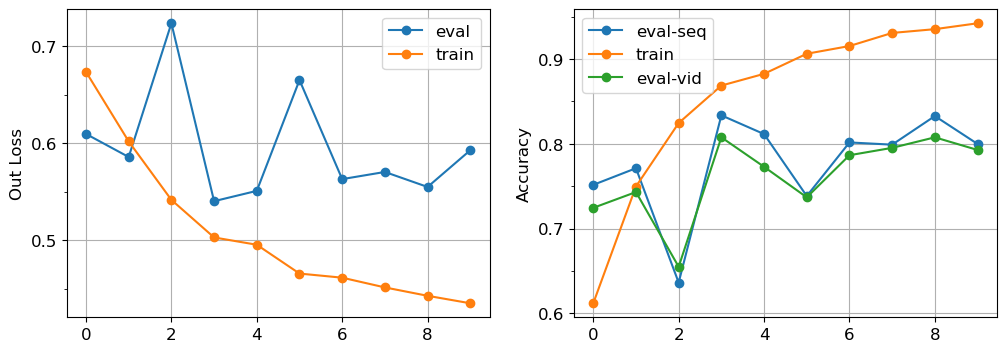

{'model_seed': 65535,
 'leaky': 96,
 'head_dim': 6,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9600000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.9700000000000002,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.05}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 1.6000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5040e-05.
Adjusting gaze weight to 3.880000000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4138e-05.
Adjusting gaze weight to 3.7636000000000016
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3289e-05.
Adjusting gaze weight to 3.6506920000000025
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2492e-05.
Adjusting gaze weight to 3.5411712400000033
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1742e-05.
Adjusting gaze weight to 3.434936102800004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1038e-05.
Adjusting gaze weight to 3.3318880197160046
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.0376e-05.
Adjusting gaze weight to 3.231931379124525
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.7531e-06.
Adjusting gaze weight to 3.13497343775079
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 9.1679e-06.
Adjusting gaze weight to 3.0409242346182666
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 8.6178e-06.
Adjusting gaze weight to 2.949696507579719
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


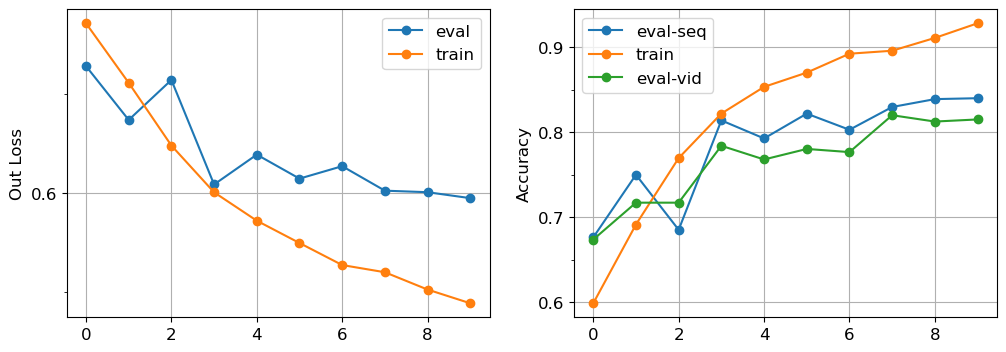

{'model_seed': 65535,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 32,
 'comp_dim': 48,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 0,
 'MHA_comp_layer_num': 2,
 'last_fc_layer_num': 3,
 'lr': 1.6e-05,
 'weight_decay': 0.001,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.9700000000000002,
 'train_seed': 1,
 'smooth_label_alpha': 0.15,
 'smooth_label_beta': 0.1}

 >> N E W   B E S T   F I T N E S S :  0.8159636062861869 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 96
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0680e-05.
Adjusting gaze weight to 3.4000000000000004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9439e-05.
Adjusting gaze weight to 2.8900000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8273e-05.
Adjusting gaze weight to 2.4565000000000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7176e-05.
Adjusting gaze weight to 2.088025000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6146e-05.
Adjusting gaze weight to 1.774821250000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5177e-05.
Adjusting gaze weight to 1.5085980625000008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4267e-05.
Adjusting gaze weight to 1.2823083531250008
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3411e-05.
Adjusting gaze weight to 1.0899621001562507
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2606e-05.
Adjusting gaze weight to 0.9264677851328132
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1850e-05.
Adjusting gaze weight to 0.7874976173628914
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


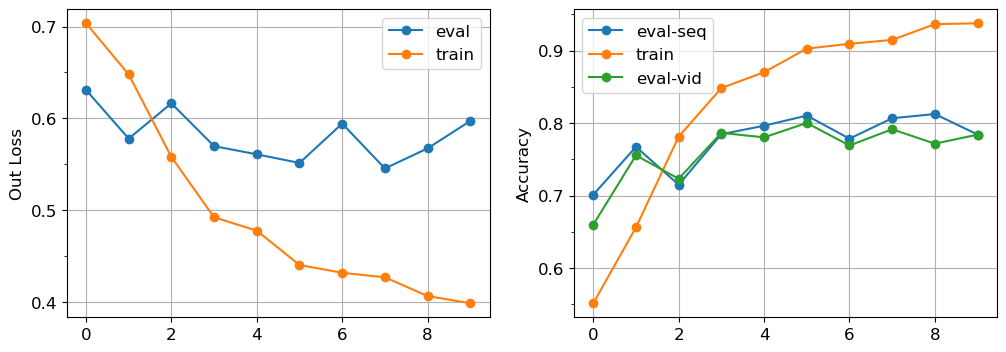

{'model_seed': 65535,
 'leaky': 96,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 64,
 'gaze_fc_layer_num': 0,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 3,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9400000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.8500000000000001,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0900e-05.
Adjusting gaze weight to 3.24
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9855e-05.
Adjusting gaze weight to 2.6244000000000005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8862e-05.
Adjusting gaze weight to 2.1257640000000007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7919e-05.
Adjusting gaze weight to 1.7218688400000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7023e-05.
Adjusting gaze weight to 1.3947137604000006
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6172e-05.
Adjusting gaze weight to 1.1297181459240007
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5363e-05.
Adjusting gaze weight to 0.9150716981984406
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4595e-05.
Adjusting gaze weight to 0.741208075540737
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3865e-05.
Adjusting gaze weight to 0.6003785411879969
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3172e-05.
Adjusting gaze weight to 0.48630661836227757
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


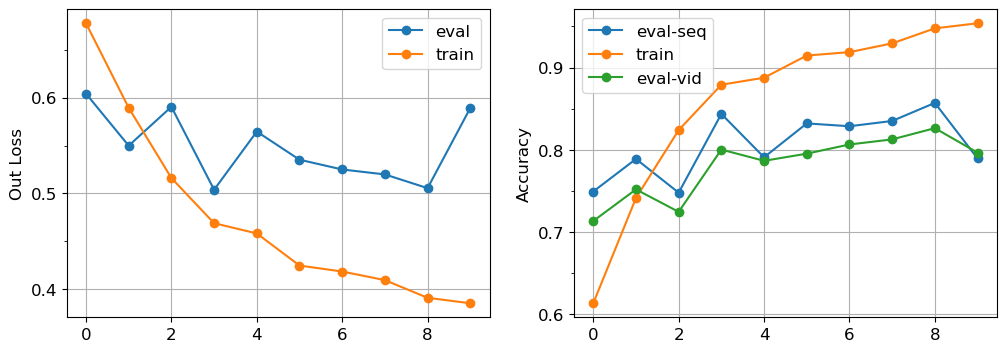

{'model_seed': 65535,
 'leaky': 64,
 'head_dim': 4,
 'dim_per_head': 64,
 'comp_dim': 48,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 1,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 2.2e-05,
 'weight_decay': 1e-05,
 'gamma': 0.9500000000000001,
 'gaze_weight': 4.0,
 'gaze_gamma': 0.81,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.0}

 >> N E W   B E S T   A C C :  0.8570071258907364 
 >> N E W   B E S T   V I D   A C C :  0.826302729528536 
------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 5.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 2.2000e-05.
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 2.0680e-05.
Adjusting gaze weight to 4.850000000000001
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.9439e-05.
Adjusting gaze weight to 4.704500000000002
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.8273e-05.
Adjusting gaze weight to 4.563365000000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.7176e-05.
Adjusting gaze weight to 4.426464050000003
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.6146e-05.
Adjusting gaze weight to 4.293670128500004
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.5177e-05.
Adjusting gaze weight to 4.164860024645005
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.4267e-05.
Adjusting gaze weight to 4.039914223905656
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.3411e-05.
Adjusting gaze weight to 3.9187167971884875
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.2606e-05.
Adjusting gaze weight to 3.8011552932728336
--------------------------------------------------


--------------------------------------------------
Adjusting learning rate of group 0 to 1.1850e-05.
Adjusting gaze weight to 3.6871206344746494
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------


--------------------------------------------------


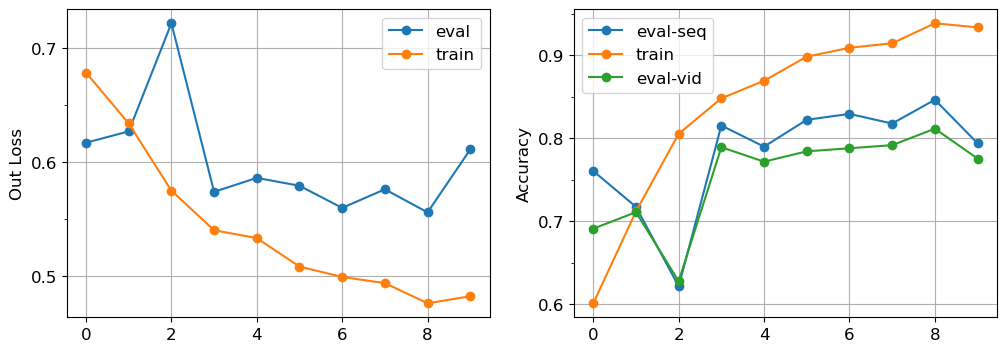

{'model_seed': 1024,
 'leaky': 64,
 'head_dim': 6,
 'dim_per_head': 64,
 'comp_dim': 96,
 'gaze_fc_layer_num': 2,
 'MHA_fc_layer_num': 2,
 'MHA_comp_layer_num': 1,
 'last_fc_layer_num': 2,
 'lr': 2.2e-05,
 'weight_decay': 1e-06,
 'gamma': 0.9400000000000001,
 'gaze_weight': 5.0,
 'gaze_gamma': 0.9700000000000002,
 'train_seed': 256,
 'smooth_label_alpha': 0.1,
 'smooth_label_beta': 0.1}

------------------------------

 >> Starting a new run ...

Key config:

 - Train DS:            10.0% WDF
 - Test DS:             100.0% WDF
 - Loss Type:           standard + Gaze * 4.00
 - Model Structure:     Basic + Leaky * 64
------------------------------
Adjusting learning rate of group 0 to 1.8000e-05.
--------------------------------------------------


--------------------------------------------------


In [ ]:
for iter_num in range(max_iter):
    run_pop(iter_num)
    get_new_pop(iter_num + 1)
    print("==========\n >> I T E R A T I O N   ", iter_num + 1, "\n==========")
    print(" >> Best Vid Acc: ", best_vid_acc['value'], " (", best_vid_acc['ID'], ")")
    print(" >> Best Acc: ", best_acc['value'], " (", best_acc['ID'], ")")
    print(" >> Best Loss: ", best_loss['value'], " (", best_loss['ID'], ")")
    print(" >> Best Fitness: ", best_fitness['value'], " (", best_fitness['ID'], ")")
    # Plot fitness-iter figure
    plt.figure(figsize=(8,2))
    plt.rcParams['font.size'] = 6
    plt.plot(mean_fitness_record, 'o-')
    plt.title("Fitness-Iteration")
    plt.grid(True)
    plt.show()

In [ ]:
from Core.EvaluateManager import EvaluateManager
from Config import Config
config = Config()
config.basic.tryID = 'final'
config.train.enable = False
eval_man = EvaluateManager(config)
vid_acc, acc, loss, detail_vid, detail_seq = eval_man.evaluate('Checkpoints/final/checkpoint_39.pth')